# ARIMA, SARIMA and Exponential Smoothing models

This notebook has the purpose to create 3 models: 

- ARIMA model
- SARIMA model
- Exponential Smoothing

These models can be used to forecast any type of time series, the goal with this notebook is to create these forecast models for domestic hot water (DHW) and electrical energy consumptions (the energy to heat the water)

For this notebook it will be created an ARIMA, a SARIMA and an Exponential Smoothing model for one set of data as an example, but these models can be reproduced for any time series


**1) Import of the packages and libraries**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import seaborn as sn
from statsmodels.tsa.stattools import acf

**2) Import of the data**

The first thing is to select the data that it will be used, the data referent to DHW and electrical energy consumptions for residential apartments will be used

A random data was chosen for this example: from 26/01/2021 to 31/01/2021

The important aspect is the duration, 5 days

All the code was written considering this duration, if changed it will be necessary to altere the size of training, testing and forescating, these topics will be discussed later in this notebook

Down below the data must be chosen, in this example the data chosen is: "ap.25 energy consumption"

In [2]:
#Energy Consumption
df25 = pd.read_csv ('/Users/belin/OneDrive/Documentos/Donnes_Pird/25-EC.csv', parse_dates=['Date'], index_col=['Date'])
df25 = df25 ['2021-01-26 00:00:00' : '2021-01-31 00:00:00']

**3) Resample the data in a time step of 1 hour**

The data is measured approximately each 3 minutes, so in order to have a better analysis during 5 days a resample of the data in a time step of 1 hour will be done

Resampling the data in time steps of 1 hour it will give 120 values

In [3]:
#Energy consumption
s = df25.Value.resample('H').mean() 

**4) Visualization of the data**

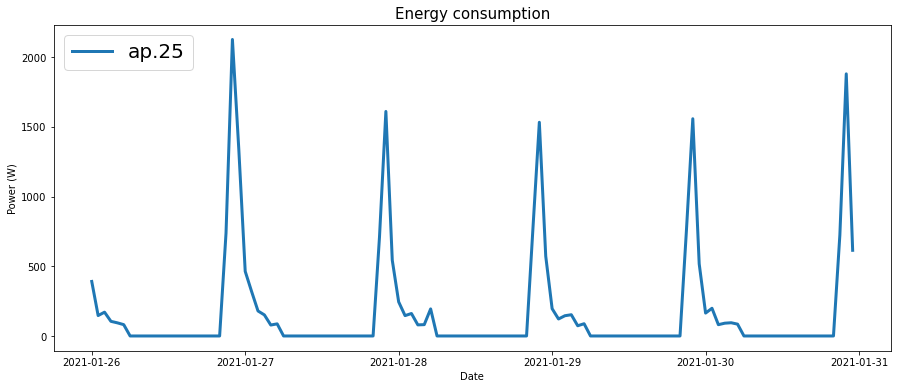

In [4]:
#Energy
plt.figure(figsize=(15,6))
plt.plot(s, label='ap.25', lw=3 ) 
plt.xlabel('Date')
plt.ylabel('Power (W)')
plt.title('Energy consumption', fontsize=15)
plt.legend(loc='upper left', fontsize=20)
plt.show()

**5) Verify if the data is stationary using Dickey-Fuller**

Normally if p-value is under 0,05 the data is considered as stationary. Otherwise differentiation will be necessary until the p-value is lower or equal to 0,05

To verify if the data is stationary a Dickey-Fuller test is used. The test will be done without differentiaition and with 1 differentiation for the data chosen

To verify with 2 differentiation, it is necessary to add "diff().diff()." after "s.", for 3,4... differentiaiton the same principle is applied


**5.1) Without differentiation**

In [5]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(s.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.967524
p-value: 0.000026


**5.2) With 1 differentiation**

In [6]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result1 = adfuller(s.diff().dropna())
print('ADF Statistic: %f' % result1[0])
print('p-value: %f' % result1[1])

ADF Statistic: -7.788663
p-value: 0.000000


In the example the data is already stationary without differentiation, so we can consider "d=0", otherwise the "d" equals the number of differentiations

**6) Division of the data in training and testing**

A division of the data is necessary, one part for train the model and a second part for test the model

It will be considered a ratio of 80:20 

- 80% training
- 20% testing

In this case (5 days with time step of 1h) there are 120 values, so 96 values are for training and 24 are for testing

In [7]:
train = s[:96]   
test = s[96:]

**7) ARIMA Model**

ARIMA is a univariate time series model with 3 components: 

- Autoregressive (AR): responsible for forecasting future points from a linear regression
- Integrate Average (I): resposible for the differentiation of the data
- Moving Average (MA): responsible for performing a regression to forecast future values, but in contrast to the AR component, this regression is based on past errors and not on past observations.

ARIMA models are frequently indicated as ARIMA (p,d,q), where:

- p represents the AR component
- d represents the I component
- q represents the MA component



**8) Creation of the model using AUTO ARIMA**

AUTO ARIMA automatically selects the parameters of ARIMA model

The inputs are the data for trainig the model (in this case the variable "train") and d (differentiation parameter)

- d=0 data is stationary
- d>0 when data was differentiated

Even though Dickey-Fuller test gives the parameter "d", sometimes the model that was more suitible using another "d".

For this raison it is strongly recommended to test for d=0 and d=1 (usually 1 differentiation is enough) and compare the results to choose the model that is more suitible


For a better understanding of the function:
https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [8]:
#! pip install pmdarima
import pmdarima as pm
model_auto = pm.auto_arima(train, d=0, trace=False)                 
print(model_auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   96
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -676.820
Date:                Thu, 26 Jan 2023   AIC                           1361.639
Time:                        14:53:26   BIC                           1371.897
Sample:                    01-26-2021   HQIC                          1365.786
                         - 01-29-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    127.6905    110.155      1.159      0.246     -88.209     343.590
ar.L1          0.2636      0.124      2.123      0.034       0.020       0.507
ma.L1          0.6993      0.130      5.368      0.0

The model summary gives the most suitible ARIMA model (p,d,q), in this case ARIMA (1,0,1)

in model_auto1 = ARIMA (train, order=(1, 0, 1)) replace the values for the parameters (p,d,q) chosen by AUTO ARIMA, in the example (1,0,1)

In [9]:
from statsmodels.tsa.arima.model import ARIMA  
model_auto1 = ARIMA(train, order=(1, 0, 1)) 
fitted_auto1 = model_auto1.fit() 
fc_auto = fitted_auto1.forecast(24, alpha=0.05)


fc_auto is the forescast, in this case it has 24 values (20% testing)

**8.1) Plot of the testing, traininig and forescast (ARIMA Model)**

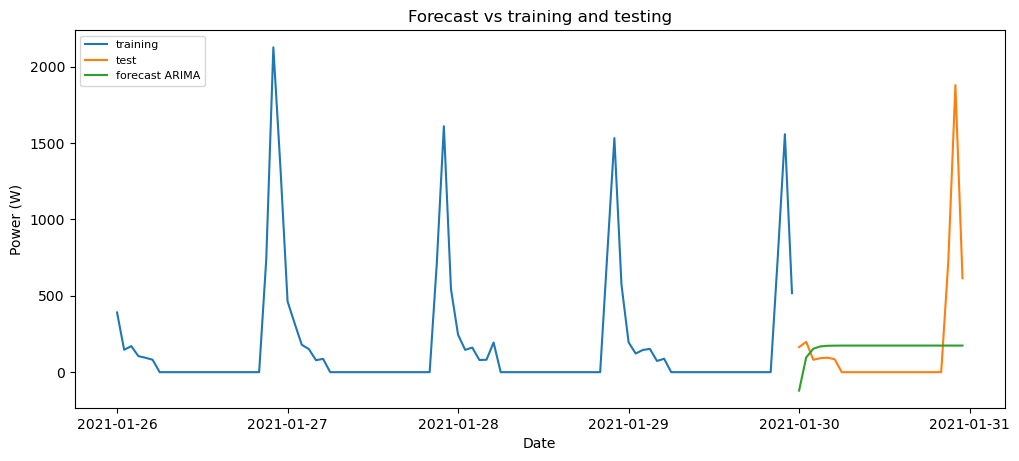

In [10]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training') 
plt.plot(test, label='test') 
plt.plot(fc_auto, label='forecast ARIMA') 
plt.title('Forecast vs training and testing')
plt.xlabel('Date')
plt.ylabel('Power (W)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**9) Model evaluation**

3 types of evaluation will be done :

- Mean Absolute Percentage Error (MAPE): 

$$\frac{1}{n} \sum_{t=1}^{n}\frac{|F_{t} - A_{t}|} {|A_{t}|}$$

- Mean Absolute Error (MAE):

$$\frac{1}{n} \sum_{t=1}^{n}|F_{t} - A_{t}|$$

        Where the values are:

$$F_{t}=forecast$$
$$A_{t}=actual$$

- Correlation

In [11]:
def forecast_accuracy_auto (forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    mae = np.mean(np.abs(forecast - actual))   
    corr = (np.corrcoef(forecast, actual)[0,1]) * 100   
    
    return({'mape':mape, 'mae': mae, 'correlation (%)':corr})

Error_Arima = forecast_accuracy_auto (fc_auto, test)
print(Error_Arima)

{'mape': inf, 'mae': 250.5656515456017, 'correlation (%)': -0.09361960591638331}


A comparison of the model using d=0 and d=1 must be done as mentionned, for changing the parameter "d" go back to the section 8

The selection of the model is based in 3 criteria:

- Analysis of the errors

- Correlation

- Visual analysis of the graphs

**In this case the model chosen is the ARIMA (1,0,1)**

**10) SARIMA model**

Seasonal ARIMA or SARIMA is the ARIMA model but including seasonality

SARIMA has 7 parameters, the same 3 from ARIMA with additional 4, which are:
- P (seasonal autoregressive terms)
- D (number of seasonal differences)
- Q (number of seasonal lagged forecast errors in the prediction equation)
- m (number of periods in each season)

SARIMA model are referred as SARIMA (p,d,q) x (P,D,Q) [m]

**11) Creation of the second model using AUTO SARIMA**

In [12]:
#!pip3 install pyramid-arima
import pmdarima as pm


The same function used in item 8 will be used, but this time adding 4 new parameters mentionned before (P,D,Q)[m]

These parameters are releated with the seasonality of the data

The paramater "m" must be chosen by the user. The choice of the parameter is by analyzing the data, for example monthly data have m=12.

In the case of energy consumption m=24 showed to be suitible.

The same analysis made for ARIMA concerning the parameter "d" must be done for SARIMA for the same reasons

For a better understanding of the function:
https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html

In [13]:
smodel = pm.auto_arima(train,test='adf',max_p=3, max_q=3, m=24,start_P=0, seasonal=True,d=1, D=1, trace=False, 
                       error_action='ignore', suppress_warnings=True, stepwise=True)

smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 24)   Log Likelihood                -432.296
Date:                            Thu, 26 Jan 2023   AIC                            868.591
Time:                                    14:54:05   BIC                            873.116
Sample:                                01-26-2021   HQIC                           870.391
                                     - 01-29-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24      -0.2454      0.075     -3.267      0.001      -0.393      -0.098
sigma2      1.126e+04    761.678     14.781      0.000    9765.735    1.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               614.66
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The smodel summary gives the most suitible ARIMA model (p,d,q ) x (P,D,Q,m)

in smodel1 = ARIMA (train, order=(0, 1, 0), seasonal_order = (1,1,0,24)) replace the values for the parameters (p,d,q) (P,D,Q,m) chosen by AUTO ARIMA

In [14]:
smodel1 = ARIMA(train, order=(0, 1, 0), seasonal_order = (1, 1, 0, 24)) 
fitted_smodel1 = smodel1.fit()
fc_smodel = fitted_smodel1.forecast(24, alpha=0.05) 

fc_smodel is the forescast, in this case it has 24 values (20% testing)

**11.1) Plot of the testing, traininig and forescast (SARIMA Model)**

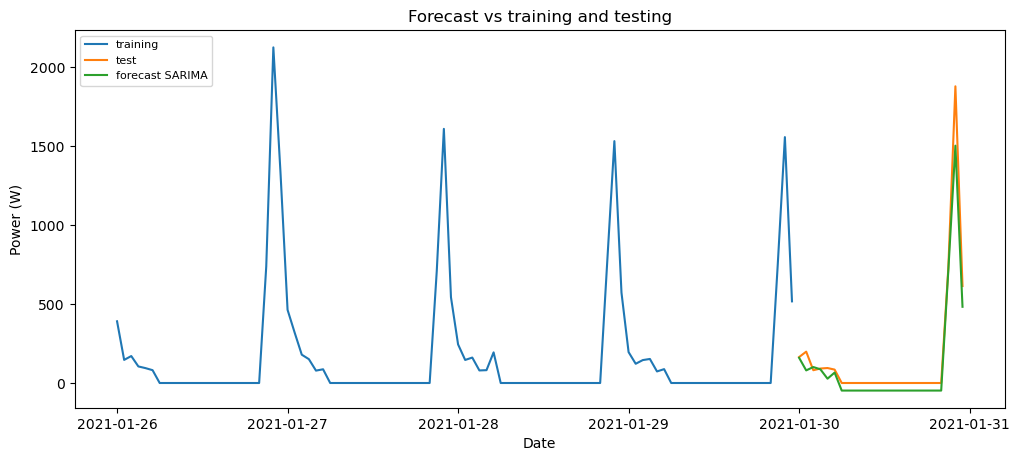

In [15]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training') 
plt.plot(test, label='test') 
plt.plot(fc_smodel, label='forecast SARIMA') 
plt.title('Forecast vs training and testing')
plt.xlabel('Date')
plt.ylabel('Power (W)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**12) Model Evaluation**

In this section the same model evaluations from the section 9 were used

In [16]:
def forecast_accuracy_SARIMA (forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    mae = np.mean(np.abs(forecast - actual))    
    corr = (np.corrcoef(forecast, actual)[0,1]) * 100   
   
    return({'mape':mape,'mae': mae, 'correlation(%)':corr})

Error_Sarima = forecast_accuracy_SARIMA (fc_smodel, test)
print(Error_Sarima)

{'mape': inf, 'mae': 61.49667739284277, 'correlation(%)': 99.35528364668934}


As in the ARIMA model, when analyzing SARIMA model a comparison using d=0 and d=1 must be done, it is due the same reasons mentionned for the ARIMA model

**In this case the model chosen is SARIMA (0,1,0) x (1,1,0)[24]**

The creation of the ARIMA and SARIMA models were based in the tutorial available at: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/.

If more informations are needed this website may help

**13) Exponential Smoothing model**

The Exponential Smoothing model is based in predicting the results as weighted averages of past values. The more recent observations are more heavily weighted, being more influential, and the less recent observation are weighted by a decreasing ratio. 
As the SARIMA model, this model also possess a seasonality parameter, called M, similar from de parameter "m" from SARIMA, which is the number of periods in each season, this paramater must be chosen by the user. The choice of the parameter is by analyzing the data. The seasonality can be :

- Additive : seasonal variation of the time series remains unchanged in size compared to the level of the series
- Multiplicative : when this variation is proportional to the level of the series

If the data posses trend, the model demands the choice beetwen 2 types of trend :

- Additive : if the ratio of trend is constant, that means the graph of the data by the time is a straight line
- Multiplicative : If the ratio of trend is not constant, is exponential

For a better understanding of the function:https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

**13.1) Decomposition of the data**

A decomposition of the data will help us analysing the data to see the trend and the seasonality

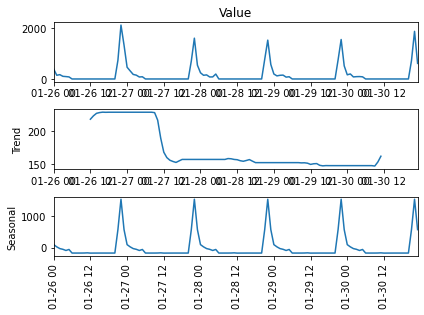

In [17]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(s, model='additive').plot(resid=False,)
plt.xticks(rotation ='vertical')
plt.show()

In this case the trend does not exist and the seasonality is additive

**14) Creation of ES model**

In the code below it is necessary to indicate the :

- The data (in this case "train")
- The trend (from the analysis of the topic 13.1) ("None" in this case)
- The type of seasonality (from the analysis of the topic 13.1) ("add" in this case)
- The number of periods in each season (parameter M) (in this case 24)

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_ES = ExponentialSmoothing(train, trend=None, seasonal='add', 
                                seasonal_periods=24)                   
fitted_ES = model_ES.fit()
fc_ES = fitted_ES.forecast(24)

fc_ES is the forescast, in this case it has 24 values (20% testing)

**14.1) Plot of the testing, traininig and forescast (ES Model)**

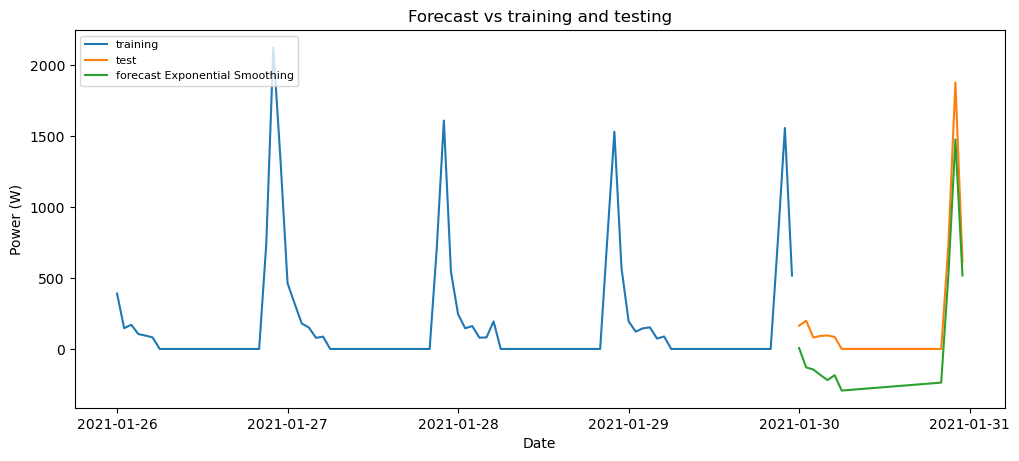

In [19]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training') 
plt.plot(test, label='test') 
plt.plot(fc_ES, label='forecast Exponential Smoothing') 
plt.title('Forecast vs training and testing')
plt.xlabel('Date')
plt.ylabel('Power (W)')
plt.legend(loc='upper left', fontsize=8)
plt.show()

**15) Model evaluation**

In [20]:
def forecast_accuracy_auto (forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    corr = (np.corrcoef(forecast, actual)[0,1]) * 100   # corr
    return({'mape':mape, 'mae': mae, 'corr(%)':corr})

Error_ES = forecast_accuracy_auto (fc_ES, test)
print(Error_ES)

{'mape': inf, 'mae': 261.21178140732013, 'corr(%)': 99.06501912822556}


**16) Comparison between ARIMA, SARIMA and Exponential Smoothing**

Now a comparison of the 3 models is possible.
- Firstly, a visualization of the graphs 

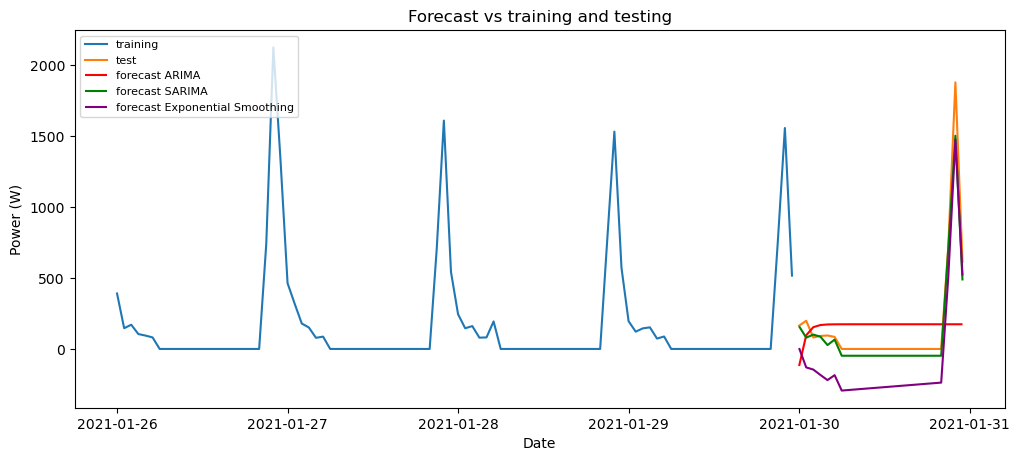

In [21]:
import math
from collections import OrderedDict

linestyles_dict = OrderedDict(
    [('solid',               (0, ())),
     
     ('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 5))),
     ('densely dotted',      (0, (1, 1))),

     ('loosely dashed',      (0, (5, 10))),
     ('dashed',              (10, (12, 11))),
     ('densely dashed',      (0, (5, 1))),

     ('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 5, 1, 5))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])


plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training') 
plt.plot(test, label='test') 
plt.plot(fc_auto,color='red', 
         linestyle = linestyles_dict['solid'], 
         label='forecast ARIMA') 
plt.plot(fc_smodel, color='green', 
         linestyle = linestyles_dict['solid'], 
         label='forecast SARIMA') 
plt.plot(fc_ES, color='purple', 
         linestyle = linestyles_dict['solid'],
         label='forecast Exponential Smoothing') 
plt.title('Forecast vs training and testing')
plt.xlabel('Date')
plt.ylabel('Power (W)')
plt.legend(loc='upper left', fontsize=8)
plt.show()


- A comparisation of the loss functions for each model

In [22]:
Error_Arima = pd.DataFrame(list(Error_Arima.items()),columns = ['Loss function','Value'])
Error_Sarima = pd.DataFrame(list(Error_Sarima.items()),columns = ['Loss function','Value'])
Error_ES = pd.DataFrame(list(Error_ES.items()),columns = ['Loss function','Value'])
Comp_A_S = Error_Arima[['Loss function','Value']].copy()

Comp_A_S.insert(1, 'Value Sarima', Error_Sarima.Value)
Comp_A_S.rename(columns = {'Value':'Value ARIMA'}, inplace = True)
Comp_A_S.insert(1, 'Value ES', Error_ES.Value)

print(Comp_A_S)

     Loss function    Value ES  Value Sarima  Value ARIMA
0             mape         inf           inf          inf
1              mae  261.211781     61.496677   250.565652
2  correlation (%)   99.065019     99.355284    -0.093620


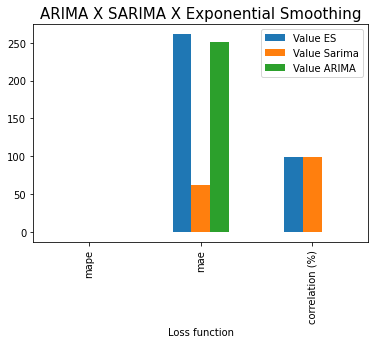

In [23]:
Comp_A_S.plot(kind = 'bar', x = 'Loss function')
plt.title('ARIMA X SARIMA X Exponential Smoothing', fontsize=15)
plt.legend(loc='upper right', fontsize=10)
plt.show()


- In this example the SARIMA model showed a lower MAE and a higher correlation than the ARIMA and Exponential models. In this case being the best model.

- Both SARIMA and Exponential Smoothing showed decent results, mainly because of their capacity of undertanding seasonality.

- It can be concluded that the SARIMA and Exponential Smoothing models were capable to predict with a high accuracy the pattern of the energy consumption for this apartment.